# **Domain Adaptation With Domain-Adversarial Training of Neural Networks**

## **Important Libraries**

### **Install**

In [1]:
!pip install -q --no-cache-dir lightning torchmetrics

### **Import**

In [2]:
try:
    import lightning as L
except:
    import lightning as L

from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from torchmetrics.classification import Accuracy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

from torch.autograd import Function

from torchvision.transforms.v2 import (
    Compose,
    ToTensor,
    Resize,
    Lambda,
    RandomInvert,
    RandomAffine,
    RandomChannelPermutation,
    RandomPhotometricDistort,
    Normalize,
    RandomApply,
)
from torchvision.datasets import SVHN, VisionDataset
from torchvision.datasets.utils import (
    _flip_byte_order,
    check_integrity,
    download_url,
    download_and_extract_archive,
)
from torchvision.models import (
    regnet_y_400mf,
    RegNet_Y_400MF_Weights,
)

from urllib.error import URLError

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

from PIL import Image

from functools import partial

import codecs

import os
import sys
import math
import copy
import time
import random
import warnings

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['axes.facecolor'] = 'lightgray'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

## **Configuration**

In [3]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
EPOCH = 50
NUM_CLASSES = 10
LEARNING_RATE = 1e-3
BASE_LR_SCALE = 1e-4
EARLY_STOPPING_PATIENCE = 5

In [4]:
METRIC_TO_MONITOR = "val_acc"
METRIC_MODE = "max"

In [5]:
os.makedirs("experiment", exist_ok=True)
os.makedirs("experiment/training", exist_ok=True)
os.makedirs("experiment/dataset", exist_ok=True)
os.makedirs("experiment/model", exist_ok=True)
EXPERIMENT_DIR = "experiment/"

In [6]:
SEED = int(np.random.randint(2147483647))
print(f"Random seed: {SEED}")

Random seed: 1387014629


## **Dataset**

### **Utils**

### Change Note (near Cell 15)
- Added ImageNet normalization to both `TRANSFORM` and `TRANSFORM_AUGMENTATION` using `Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))`.
- Removed the previous `Lambda` scaling to `[-1, 1]`.
- Moderated source augmentations (affine/color) to reduce distribution shift collapse when using a pretrained backbone.

- Fixed transform error: wrapped `RandomChannelPermutation()` with `RandomApply(p=0.05)` since it doesn’t accept `p` directly.

In [7]:
# ImageNet normalization expected by pretrained RegNet
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

TRANSFORM = Compose(
    [
        Resize((IMAGE_SIZE, IMAGE_SIZE)),
        ToTensor(),
        Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)
TRANSFORM_AUGMENTATION = Compose(
    [
        RandomAffine(
            degrees=30.0,
            translate=(0.05, 0.05),
            scale=(0.9, 1.1),
            shear=5.0,
        ),
        # Keep color perturbations lighter to avoid collapse
        RandomInvert(p=0.05),
        RandomPhotometricDistort(p=0.3),
        Resize((IMAGE_SIZE, IMAGE_SIZE)),
        RandomApply([RandomChannelPermutation()], p=0.05),
        ToTensor(),
        Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ]
)

In [8]:
def get_int(b: bytes) -> int:
    return int(codecs.encode(b, "hex"), 16)

In [9]:
SN3_PASCALVINCENT_TYPEMAP = {
    8: torch.uint8,
    9: torch.int8,
    11: torch.int16,
    12: torch.int32,
    13: torch.float32,
    14: torch.float64,
}

In [10]:
def read_sn3_pascalvincent_tensor(
    path: str,
    strict: bool = True,
) -> torch.Tensor:
    """Read a SN3 file in "Pascal Vincent" format
    (Lush file 'libidx/idx-io.lsh'). Argument may be a filename,
    compressed filename, or file object.
    """
    # read
    with open(path, "rb") as f:
        data = f.read()

    # parse
    if sys.byteorder == "little":
        magic = get_int(data[0:4])
        nd = magic % 256
        ty = magic // 256
    else:
        nd = get_int(data[0:1])
        ty = (
            get_int(data[1:2])
            + get_int(data[2:3]) * 256
            + get_int(data[3:4]) * 256 * 256
        )

    assert 1 <= nd <= 3
    assert 8 <= ty <= 14
    torch_type = SN3_PASCALVINCENT_TYPEMAP[ty]
    s = [get_int(data[4 * (i + 1) : 4 * (i + 2)]) for i in range(nd)]

    if sys.byteorder == "big":
        for i in range(len(s)):
            s[i] = int.from_bytes(
                s[i].to_bytes(4, byteorder="little"),
                byteorder="big",
                signed=False,
            )

    parsed = torch.frombuffer(bytearray(data), dtype=torch_type, offset=(4 * (nd + 1)))

    # The MNIST format uses the big endian byte order, while `torch.frombuffer`
    # uses whatever the system uses. In case that is little endian and the dtype
    # has more than one byte, we need to flip them.
    if sys.byteorder == "little" and parsed.element_size() > 1:
        parsed = _flip_byte_order(parsed)

    assert parsed.shape[0] == np.prod(s) or not strict
    return parsed.view(*s)

In [11]:
def read_image_file(path: str) -> torch.Tensor:
    x = read_sn3_pascalvincent_tensor(path, strict=False)
    if x.dtype != torch.uint8:
        raise TypeError(f"x should be of dtype torch.uint8 instead of {x.dtype}")
    if x.ndimension() != 3:
        raise ValueError(f"x should have 3 dimension instead of {x.ndimension()}")
    return x

In [12]:
def read_label_file(path: str) -> torch.Tensor:
    x = read_sn3_pascalvincent_tensor(path, strict=False)
    if x.dtype != torch.uint8:
        raise TypeError(f"x should be of dtype torch.uint8 instead of {x.dtype}")
    if x.ndimension() != 1:
        raise ValueError(f"x should have 1 dimension instead of {x.ndimension()}")
    return x.long()

In [13]:
class DomainAdaptationDataset(VisionDataset):
    mirrors = [
        "http://yann.lecun.com/exdb/mnist/",
        "https://ossci-datasets.s3.amazonaws.com/mnist/",
    ]

    resources = [
        ("train-images-idx3-ubyte.gz", "f68b3c2dcbeaaa9fbdd348bbdeb94873"),
        ("train-labels-idx1-ubyte.gz", "d53e105ee54ea40749a09fcbcd1e9432"),
    ]

    split_list = [
        "http://ufldl.stanford.edu/housenumbers/train_32x32.mat",
        "train_32x32.mat",
        "e26dedcc434d2e4c54c9b2d4a06d8373",
    ]

    def __init__(self, root: str) -> None:
        super().__init__(root)

        self.url = self.split_list[0]
        self.filename = self.split_list[1]
        self.file_md5 = self.split_list[2]

        self.download_mnist()
        self.download_svhn()

        if not self._check_exists_mnist and not self._check_integrity_svhn:
            raise RuntimeError(
                "Dataset not found. You can use download=True to download it"
            )

        self.data_mnist, self.labels_mnist = self._load_data_mnist()

        loaded_mat = sio.loadmat(os.path.join(self.root, self.filename))
        self.data_svhn = np.transpose(loaded_mat["X"], (3, 2, 0, 1))

    def _load_data_mnist(self):
        image_file = f"train-images-idx3-ubyte"
        data = read_image_file(os.path.join(self.raw_folder, image_file))

        label_file = f"train-labels-idx1-ubyte"
        targets = read_label_file(os.path.join(self.raw_folder, label_file))

        return data, targets

    def __getitem__(self, index: int):
        index_mnist = (
            index % len(self.data_mnist)
            if index > (len(self.data_mnist) - 1)
            else index
        )
        img_mnist = self.data_mnist[index_mnist]
        img_svhn = self.data_svhn[index]

        label_mnist = int(self.labels_mnist[index_mnist])

        img_mnist = Image.fromarray(img_mnist.numpy(), mode="L").convert("RGB")
        img_svhn = Image.fromarray(np.transpose(img_svhn, (1, 2, 0)))

        img_mnist = TRANSFORM_AUGMENTATION(img_mnist)
        img_svhn = TRANSFORM(img_svhn)

        return img_mnist, img_svhn, label_mnist

    def __len__(self) -> int:
        return len(self.data_svhn)

    @property
    def raw_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, "raw")

    @property
    def processed_folder(self) -> str:
        return os.path.join(self.root, self.__class__.__name__, "processed")

    @property
    def _check_exists_mnist(self) -> bool:
        return all(
            check_integrity(
                os.path.join(
                    self.raw_folder, os.path.splitext(os.path.basename(url))[0]
                )
            )
            for url, _ in self.resources
        )

    @property
    def _check_integrity_svhn(self) -> bool:
        return check_integrity(
            os.path.join(self.root, self.filename),
            self.file_md5,
        )

    def download_svhn(self) -> None:
        if self._check_integrity_svhn:
            return

        download_url(self.url, self.root, self.filename, self.file_md5)

    def download_mnist(self) -> None:
        """Download the MNIST data if it doesn't exist already."""

        if self._check_exists_mnist:
            return

        os.makedirs(self.raw_folder, exist_ok=True)

        # download files
        for filename, md5 in self.resources:
            for mirror in self.mirrors:
                url = f"{mirror}{filename}"
                try:
                    print(f"Downloading {url}")
                    download_and_extract_archive(
                        url,
                        download_root=self.raw_folder,
                        filename=filename,
                        md5=md5,
                    )
                except URLError as error:
                    print(f"Failed to download (trying next):\n{error}")
                    continue
                finally:
                    print()
                break
            else:
                raise RuntimeError(f"Error downloading {filename}")

### **Load**

In [14]:
TrainDataset = DomainAdaptationDataset(root="experiment/dataset")
ValDataset = SVHN(
    root="experiment/dataset",
    split="test",
    transform=TRANSFORM,
    download=True,
)
TestDataset = ValDataset

Using downloaded and verified file: experiment/dataset/test_32x32.mat


## **Utils**

In [15]:
class AvgMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.scores = list()

    def update(self, val):
        self.scores.append(val)

    def show(self):
        scores = torch.stack(self.scores)
        return torch.mean(scores)

## **Model**

In [16]:
class GradientReversalLayer(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.lambda_
        return output, None

### Change Note (near Cell 25)
- Updated `GradientReversalLayer` to accept a `lambda_` parameter and scale gradients by `-lambda_` during backpropagation. This enables the classic DANN scheduling of the GRL strength.

In [ ]:
class DANN(L.LightningModule):
    def __init__(self):
        super().__init__()

        self.batch_size = BATCH_SIZE
        self.max_epoch = EPOCH
        self.lr = LEARNING_RATE
        self.lr_now = self.lr * 1e3

        self.backbone = regnet_y_400mf(
            weights=RegNet_Y_400MF_Weights.DEFAULT,
        )
        # Infer pooled feature dimension from backbone
        feat_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(feat_dim, 110, bias=False),
            nn.BatchNorm1d(110),
            nn.ReLU(True),
            nn.Dropout(p=0.4),
            nn.Linear(110, 110, bias=False),
            nn.BatchNorm1d(110),
            nn.ReLU(True),
            nn.Dropout(p=0.4),
            nn.Linear(110, 10),
        )

        self.domain_classifier = nn.Sequential(
            nn.Linear(feat_dim, 110, bias=False),
            nn.BatchNorm1d(110),
            nn.ReLU(True),
            nn.Dropout(p=0.4),
            nn.Linear(110, 2),
        )

        self.automatic_optimization = False

        self.train_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )

        self.val_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )

        self.test_accuracy = Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES,
        )

        self.train_loss = list()
        self.val_loss = list()

        self.train_acc = list()
        self.val_acc = list()

        self.train_loss_recorder = AvgMeter()
        self.val_loss_recorder = AvgMeter()

        self.train_acc_recorder = AvgMeter()
        self.val_acc_recorder = AvgMeter()

        self.sanity_check_counter = 1

        # Track global progress for GRL schedule
        self.total_train_steps = None
        self.current_train_step = 0

    def forward(self, x, grl_lambda: float = 1.0):
        x = self.backbone.stem(x)
        x = self.backbone.trunk_output(x)

        x = self.backbone.avgpool(x)
        x = x.flatten(start_dim=1)

        x_class = self.backbone.fc(x)

        if not self.training:
            return x_class

        # Use GRL with factor 1.0; weight domain losses externally
        x_reverse = GradientReversalLayer.apply(x, 1.0)
        x_domain = self.domain_classifier(x_reverse)

        return x_class, x_domain

    def _compute_grl_lambda(self):
        # DANN schedule: lambda(p) = 2/(1+exp(-10p)) - 1
        # p in [0,1] is overall training progress
        if self.total_train_steps is None or self.total_train_steps == 0:
            return 1.0
        p = min(1.0, max(0.0, self.current_train_step / float(self.total_train_steps)))
        return 2.0 / (1.0 + math.exp(-10.0 * p)) - 1.0

    def on_fit_start(self):
        # compute total steps once dataloaders are set
        train_loader = self.train_dataloader()
        steps_per_epoch = math.ceil(
            len(train_loader.dataset) / float(train_loader.batch_size)
        )
        self.total_train_steps = steps_per_epoch * self.max_epoch
        self.current_train_step = 0

    def training_step(self, batch, batch_nb):
        source_images, target_images, source_labels = batch

        source_labels = source_labels.view(source_labels.shape[0])

        lambda_grl = self._compute_grl_lambda()

        class_predictions, domain_predictions = self(source_images, grl_lambda=1.0)

        self.train_accuracy.update(class_predictions.softmax(1), source_labels)
        acc = self.train_accuracy.compute().data.cpu()

        domain_labels = torch.zeros(source_images.size(0)).long().to(self.device)

        class_loss = F.cross_entropy(class_predictions, source_labels)
        source_domain_loss = F.cross_entropy(domain_predictions, domain_labels)

        domain_labels = torch.ones(source_images.size(0)).long().to(self.device)

        _, domain_predictions = self(target_images, grl_lambda=1.0)
        target_domain_loss = F.cross_entropy(domain_predictions, domain_labels)

        opt = self.optimizers()
        opt.zero_grad()
        # Weight domain losses by lambda per DANN update rules
        loss = class_loss + lambda_grl * (source_domain_loss + target_domain_loss)
        self.manual_backward(loss)
        opt.step()

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_loss_recorder.update(loss.detach())
        self.train_acc_recorder.update(acc)

        sch = self.lr_schedulers()
        sch.step()

        # increment global step counter for GRL schedule
        self.current_train_step += 1

    def on_train_epoch_end(self):
        self.train_loss.append(self.train_loss_recorder.show().data.cpu().numpy())
        self.train_loss_recorder = AvgMeter()

        self.train_acc.append(self.train_acc_recorder.show().data.cpu().numpy())
        self.train_acc_recorder = AvgMeter()

        # reset epoch metrics
        self.train_accuracy.reset()

    def validation_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)

        if self.sanity_check_counter == 0:
            self.val_accuracy.update(y_hat.softmax(1), y)
            acc = self.val_accuracy.compute().data.cpu()

            self.log("val_loss", loss, prog_bar=True)
            self.log("val_acc", acc, prog_bar=True)

            self.val_loss_recorder.update(loss.detach())
            self.val_acc_recorder.update(acc)

    def on_validation_epoch_end(self):
        if self.sanity_check_counter == 0:
            self.val_loss.append(self.val_loss_recorder.show().data.cpu().numpy())
            self.val_loss_recorder = AvgMeter()
            acc = self.val_acc_recorder.show().data.cpu().numpy()
            lr_now_ = self.optimizers().param_groups[0]["lr"]
            if self.lr_now != lr_now_:
                self.lr_now = lr_now_
                report_str = f"[{MODEL_NAME}] Learning Rate Changed:"
                report_str += f" {lr_now_} - Epoch: {self.current_epoch}"
                print(report_str)
            self.val_acc.append(acc)
            self.val_acc_recorder = AvgMeter()
            # reset epoch metrics
            self.val_accuracy.reset()
        else:
            self.sanity_check_counter -= 1

    def test_step(self, batch, batch_nb):
        x, y = batch
        y_hat = self(x)
        y = y.view(y.shape[0])
        loss = F.cross_entropy(y_hat, y)
        self.test_accuracy.update(y_hat.softmax(1), y)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log(
            "test_acc",
            self.test_accuracy.compute(),
            prog_bar=True,
            logger=True,
        )

    def on_test_epoch_end(self):
        # reset test metrics
        self.test_accuracy.reset()

    def on_train_end(self):
        # Loss
        loss_img_file = f"experiment/training/{MODEL_NAME}_loss_plot.png"
        plt.figure()
        plt.plot(self.train_loss, color="r", label="train")
        plt.plot(self.val_loss, color="b", label="validation")
        plt.title("Loss Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.savefig(loss_img_file)
        plt.show()
        plt.clf()

        # Accuracy
        acc_img_file = f"experiment/training/{MODEL_NAME}_acc_plot.png"
        plt.figure()
        plt.plot(self.train_acc, color="r", label="train")
        plt.plot(self.val_acc, color="b", label="validation")
        plt.title("Accuracy Curves")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.savefig(acc_img_file)
        plt.show()
        plt.clf()

    def train_dataloader(self):
        return data.DataLoader(
            dataset=TrainDataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return data.DataLoader(
            dataset=ValDataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return data.DataLoader(
            dataset=TestDataset,
            batch_size=1,
            shuffle=False,
        )

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=self.lr,
        )
        cyclic = optim.lr_scheduler.CyclicLR(
            optimizer,
            base_lr=BASE_LR_SCALE * self.lr,
            max_lr=self.lr,
            cycle_momentum=False,
        )
        lr_scheduler = {
            "scheduler": cyclic,
            "interval": "step",  # step every batch
            "name": "lr",
        }

        return [optimizer], [lr_scheduler]

### Change Note (near Cell 26)
- Modified `DANN.forward` to accept `grl_lambda` and route it to `GradientReversalLayer` during training.
- Added GRL schedule `lambda(p)=2/(1+exp(-10p)) - 1` using total step progress; implemented `_compute_grl_lambda()`, `on_fit_start()`, and tracking `current_train_step`.
- Updated `training_step` to compute and pass `lambda_grl` for both source and target domain predictions.
- Inferred the feature dimension for both heads using `feat_dim = self.backbone.fc.in_features` instead of hard-coding `440`.
- Correct DANN objective: use GRL(1.0) and weight domain losses by scheduled `lambda` so θ_f sees −λ∂L_d and θ_d sees +λ∂L_d.

### Change Note (LR scheduler)
- Declared CyclicLR with `interval='step'` and `name='lr'` in `configure_optimizers` to reflect per-batch stepping with manual optimization.

### Change Note (metrics & early stopping)
- Reset torchmetrics at epoch end: `train_accuracy.reset()`, `val_accuracy.reset()`, and `test_accuracy.reset()` to avoid cross-epoch accumulation.
- Set `EARLY_STOPPING_PATIENCE = 5` and added the `EarlyStopping` callback using that value.

### Change Note (matplotlib fix)
- Fixed `on_train_end` plotting: moved `plt.show()` before `plt.clf()` and added `plt.figure()` to ensure figures display properly.

In [18]:
MODEL = DANN
MODEL_NAME = DANN.__name__
BEST_MODEL_PATH = os.path.join(
    EXPERIMENT_DIR,
    "model",
    f"{MODEL_NAME}_best.ckpt",
)

## **Training**

In [19]:
def _train_loop():
    seed_everything(SEED, workers=True)

    print(MODEL_NAME)
    model = MODEL()

    callbacks = list()

    checkpoint = ModelCheckpoint(
        monitor=METRIC_TO_MONITOR,
        dirpath=f"{EXPERIMENT_DIR}/model",
        mode=METRIC_MODE,
        filename=f"{MODEL_NAME}_best",
    )
    callbacks.append(checkpoint)

    early_stopping = EarlyStopping(
        monitor=METRIC_TO_MONITOR,
        min_delta=0.00,
        patience=EARLY_STOPPING_PATIENCE,
        verbose=False,
        mode=METRIC_MODE,
    )
    callbacks.append(early_stopping)

    if os.path.exists(BEST_MODEL_PATH):
        ckpt_path = BEST_MODEL_PATH
    else:
        ckpt_path = None

    trainer = Trainer(
        accelerator="auto",
        devices=1,
        max_epochs=EPOCH,
        logger=False,
        callbacks=callbacks,
        log_every_n_steps=5,
    )
    trainer.fit(model, ckpt_path=ckpt_path)


torch.set_float32_matmul_precision("high")
_train_loop()

[rank: 0] Seed set to 1387014629


DANN


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at experiment/model/DANN_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type               | Params | Mode 
-----------------------------------------------------------------
0 | backbone          | RegNet             | 4.0 M  | train
1 | domain_classifier | Sequential         | 48.8 K | train
2 | train_accuracy    | MulticlassAccuracy | 0      | train
3 | val_accuracy      | MulticlassAccuracy | 0      | train
4 | test_accuracy     | MulticlassAccuracy | 0      | train
-----------------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.056    Total estimated model params size (MB)
362       Modules in train mode
0         Modules in eval mode
Restored all states from the checkpoint at experiment/model/DANN_best.ckpt
SLUR

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0007330267 - Epoch: 1


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00090050995 - Epoch: 2


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0005340465999999997 - Epoch: 3


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00016758325 - Epoch: 4


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00019908009999999984 - Epoch: 5


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00056554345 - Epoch: 6


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0009320068000000003 - Epoch: 7


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0007015298499999993 - Epoch: 8


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0003350665 - Epoch: 9


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 3.1596850000000304e-05 - Epoch: 10


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0003980601999999997 - Epoch: 11


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0007645235499999999 - Epoch: 12


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0008690130999999997 - Epoch: 13


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0005025497500000003 - Epoch: 14


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0001360864000000001 - Epoch: 15


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00023057694999999926 - Epoch: 16


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0005970403000000013 - Epoch: 17


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0009635036499999997 - Epoch: 18


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0006700329999999999 - Epoch: 19


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00030356964999999963 - Epoch: 20


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 6.30937000000006e-05 - Epoch: 21


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0004295570500000009 - Epoch: 22


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0007960203999999993 - Epoch: 23


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.0008375162500000003 - Epoch: 24


Validation: |          | 0/? [00:00<?, ?it/s]

[DANN] Learning Rate Changed: 0.00047105290000000005 - Epoch: 25


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## **Testing**

In [20]:
def _test_loop():
    trainer = Trainer(accelerator="auto", logger=False)
    model = MODEL()
    trainer.test(model=model, ckpt_path=BEST_MODEL_PATH)


_test_loop()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at experiment/model/DANN_best.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at experiment/model/DANN_best.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5294755101203918     │
│         test_loss         │    3.0415849685668945     │
└───────────────────────────┴───────────────────────────┘

## **Inference**

Using downloaded and verified file: experiment/dataset/test_32x32.mat


<Figure size 640x480 with 0 Axes>

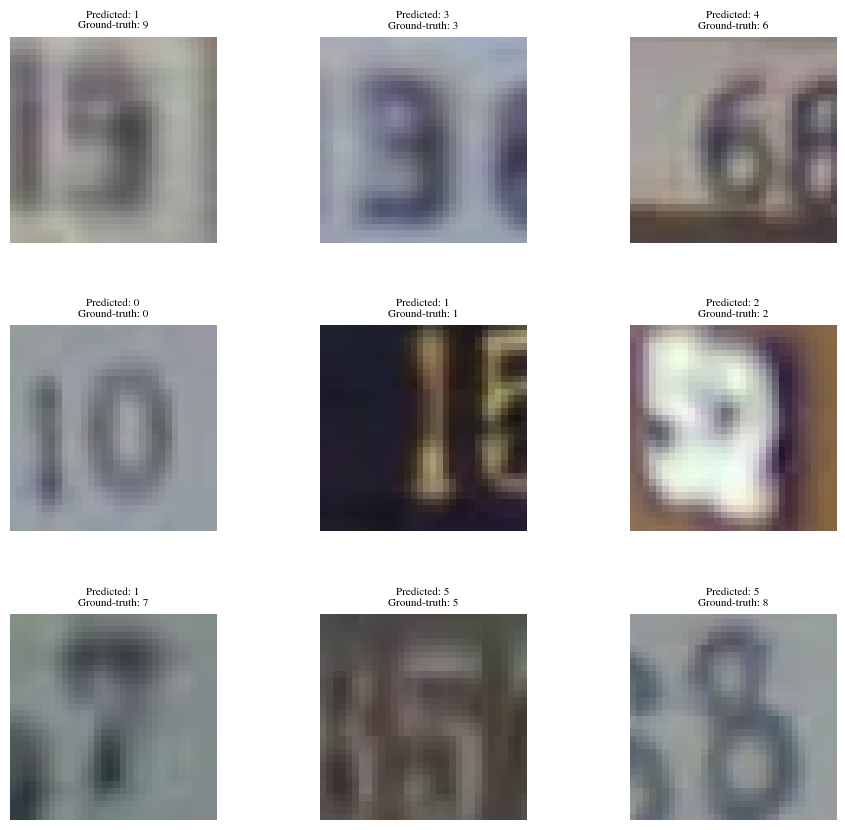

In [21]:
model = MODEL.load_from_checkpoint(BEST_MODEL_PATH)
model.eval()

plt.clf()
fig = plt.figure()
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=math.sqrt(2),
    top=math.sqrt(3),
    wspace=0.4,
    hspace=0.4,
)

class_bin = list()

InferenceDataset = SVHN(
    root="experiment/dataset/",
    split="test",
    download=True,
)

for index in range(9):
    while True:
        sample_idx = random.randint(0, len(InferenceDataset) - 1)
        image, gt_class = InferenceDataset[sample_idx]

        if not gt_class in class_bin:
            class_bin.append(gt_class)
            break
        else:
            continue

    prediction = model(
        TRANSFORM(image).to("cuda" if torch.cuda.is_available else "cpu").unsqueeze(0),
    )

    prediction.softmax(1)
    predicted_class = torch.argmax(prediction).data.cpu().numpy()

    title = f"Predicted: {predicted_class}\n"
    title += f"Ground-truth: {gt_class}"

    ax = fig.add_subplot(3, 3, index + 1)

    ax.imshow(np.array(image).astype(np.uint8))
    ax.set_title(title, fontsize=8)
    ax.set_axis_off()

plt.show()

del InferenceDataset

## Summary of Changes
- Implemented GRL lambda scheduling per DANN: `lambda(p) = 2/(1+exp(-10p)) - 1`.
- `GradientReversalLayer` now accepts `lambda_` and scales gradients by `-lambda_`.
- `DANN.forward(x, grl_lambda)` passes `grl_lambda` to GRL during training.
- Added `_compute_grl_lambda()`, `on_fit_start()` and `current_train_step` tracking; incremented the counter each training step.
- Updated `training_step` to compute and pass the scheduled `lambda_grl` for source and target domain losses.
- Fixed head input sizes by inferring `feat_dim = self.backbone.fc.in_features` for both label and domain heads (removed hard-coded 440).
- Added ImageNet normalization to both domains and removed `[-1,1]` scaling; slightly moderated source augmentations for stability with a pretrained backbone.
- Correct DANN scaling for θ_d: use GRL(1.0) and weight domain losses by scheduled `lambda` to match the saddle-point updates.
- Reset metrics each epoch (`train/val/test_accuracy.reset()`) and added `EarlyStopping` with integer `EARLY_STOPPING_PATIENCE`.
- Declared `CyclicLR` scheduler interval=`step` and name=`lr` to reflect per-batch stepping.